## Optimal Execution of Portfolio Transactions using Reinforcement Learning Methods 
### FINM 33220: FINAL PROJECT
### Edmund Tian and Joseph Padilla

### 1. Introduction 

In Optimal Exectuion of Portfolio Transactions, Almgren and Chriss provide an explicit solution to a portfolio transaction execution problem in the form of an optimal execution strategy that aims to minimize a combination of volatility risk and transactions costs.

We will explore training a Reinforcement Learning model to compute optimal execution paths of a large orders, as in the style of Almgren and Chriss. Since the Almgren and Chriss Model provides a closed form solution to the problem, we have a benchmark by which to compare our results.

### 2. Almgren-Chriss Optimal Execution Model

Following Almgren and Chriss, we define the following parameters and variables:

$X$: initial block of units of security held 

$T$: time to liquidate

$N$: number of intervals (by which to divide T), timesteps

$\tau = T/N$: length of timestep intervals

$t_k = k\tau$, for $k=0,...,N$: discrete times

$x_0,....,x_N$: the trading trajectory, where $x_k$ represents the number of units we plan to hold at time $t_k$. By convention, $x_0 = X$ and $x_N = 0$.

$n_1,...,n_N$: the trade list, where $n_k = x_{k-1} - x_k$ is the number of units sold between time $t_{k-1}$ and $t_k$.


The model assumes that prices evolve according to an discrete arithmetic random walk, given generally by:

$$S_k =S_{k-1} + \sigma \tau^{1/2} \xi_k - \tau g \left( \frac{n_k}{\tau} \right)$$

for $k = 1,...,N$ and where $\sigma$ represents the volatilty of the asset, $\xi_j$ are independent,identically-distributed random variables with distribution $\mathcal{N}(0,1)$, and $g(v)$ is the permanent impact function of the average rate of trading $v = n_k/\tau$ during the interval $t_{k-1}$ and $t_k$.

For the purposes of our project, we utilized a linear permanent impact function, which gives $g(v)$ in the form:

$$g(v) = \gamma v $$

and the price process is specified as:

$$ S_k = S_{k-1} + \sigma \tau^{1/2} \xi_k + \gamma(x_k - x_{k-1})$$

Similarly, we define the temporary impact function as:

$$ h \left(\frac{n_k}{\tau} \right) = \epsilon \text{sgn}(n_k) + \frac{\eta}{\tau} n_k$$

which introduces a temporary market impact effect due to trading within the interval. This effect alters the actual price of the share received on sale $k$ in the manner

$$ \tilde{S}_k = S_{k-1} - h \left(\frac{n_k}{\tau} \right)$$

but does not alter the market price process,$S_k$, itself.


In this project we focus on *implementation shortfall* which is the total cost of trading considering all aspects of market impact. We readily compute 

$$\begin{align*}
\text{IS} &:= XS_{0} - \sum_{k=1}^{N}n_{k}\tilde{S_{k}} \\
&= \sum_{k=1}^{N} n_{k} h(\frac{n_{k}}{\tau}) - \sum_{k=1}^{N} (S_{k} - S_{k-1}) x_{k} \\
&= \sum_{k=1}^{N} n_{k} h(\frac{n_{k}}{\tau}) - \sum_{k=1}^{N} (\sigma \tau^{1/2} \xi_k - \tau g \left( \frac{n_k}{\tau} \right)) x_{k}
\end{align*}
$$
Then the optimal exuection strategy can be determined by minimizing the utility function $u(\text{IS}) = \mathbb{E}(\text{IS}) + \lambda \mathbb{V}(\text{IS}) $ in the following constrained optimization problem:
$$ \min_{\text{IS}} \mathbb{E}(\text{IS}) + \lambda \mathbb{V}(\text{IS})$$
where 
$$\begin{align*}
\mathbb{E}(\text{IS}) &= \sum_{k=1}^{N} n_{k} h(\frac{n_{k}}{\tau}) + \sum_{k=1}^{N} \tau x_{k} g \left( \frac{n_k}{\tau} \right) \\
\mathbb{V}({\text{IS}}) &= \sigma^{2} \sum_{k=1}^{N} \tau x_{k}^{2}
\end{align*}$$


The optimal solution is then specified by the optimal trading trajectory and associated trade list as given below.

The trading trajectory is given by:

$$ x_j =  \frac{\sinh(\kappa(T-t_j))}{\sinh(\kappa T)} X $$

for $j = 0,1,...,N$

and the associated trade list:

$$ n_j = \frac{2 \sinh(\frac{1}{2} \kappa \tau)}{\sinh(\kappa T)} \cosh(\kappa(T-t_{j-\frac{1}{2}})) X$$

for $ j = 1,...,N $ and $t_{j-\frac{1}{2}} = (j-\frac{1}{2})\tau $ and where $\kappa$ satisfies 

$$ \frac{2}{\tau^2} (\cosh(\kappa \tau) - 1) = \tilde{\kappa}^2$$

with

$$ \tilde{\kappa}^2 =  \frac{\lambda \sigma^2}{\eta \left(1 - \frac{\gamma \tau}{2 \eta} \right)}$$





Now, we can visualize an implementation of this model that will serve as a benchmark for our Reinforcement Learning Model.

## Almgren-Chriss Optimal Execution Model

In [1]:
import matplotlib.pyplot as plt
import sys
import numpy as np 
import math
import decimal
from collections import namedtuple
from scipy.optimize import fsolve
import random

In [2]:
def almgren_chriss_model(S0,X,T,N,sigma,alpha,epsilon,gamma,eta,llambda):
    
    # Parameters
    tau = T/N
    t = np.linspace(0, T, N)

    # Initialize variables
    x = np.zeros(N)  # Trading trajectory
    v = np.zeros(N)  # Inventory
    n = np.zeros(N)  # Trading List
    S = np.zeros(N)  # Prices
    S_tilde = np.zeros(N) # Price after temporary impact
    x[0] = X  # Initial inventory
    v[0] = X  # Initial inventory
    n[0] = 0  # no trade before time 0
    S[0] = S0  # Initial price
    S_tilde[0] = S0

    kappa_tilde_sq = (llambda*sigma**2)/(eta*(1 - gamma*tau/(2*eta)))
    
    f = lambda kappa: (2/tau**2)*(np.cosh(kappa*tau) - 1) - kappa_tilde_sq

    kappa = fsolve(f, [kappa_tilde_sq])
    
    # Dynamics
    for i in range(1, N):
        x[i] = np.sinh(kappa*(T - t[i]))*X/np.sinh(kappa*T)
        n[i] = (2*np.sinh(0.5*kappa*tau)/np.sinh(kappa*T))*np.cosh(kappa*(T - (i-0.5)*tau))*X
        S[i] = arithmetic_random_walk(S[i-1],sigma,tau,gamma,x[i],x[i-1])
        S_tilde[i] = S[i-1] - epsilon*np.sign(n[i]) - (eta/tau)*n[i]
        v[i] = v[i-1] - n[i]
    
    return x,v,n,S,S_tilde


def arithmetic_random_walk(p,sigma,tau,gamma,new_holding,last_holding):
    xi = np.random.normal(0, 1.0, 1)[0]
    new_price = p + sigma*(tau**0.5)*xi + gamma*(new_holding - last_holding)
    return new_price

The parameters chosen here primarily follow those outlined by Almgren and Chriss. We simply update the block $X$, time to liquidation $T$, and $N$ in line with the instructions for this project.

In [3]:
S0 = 50
X = 1000
T = 5
N = 5000
sigma = 0.95
alpha = 0.02
epsilon = 1/16
gamma = 2.5*10**(-7)
eta = 2.5*10**(-6)
llambda = 10**(-6)

In [4]:
trading_trajectory, inventory, trading_list, prices, prices_tilde = almgren_chriss_model(S0,X,T,N,sigma,alpha,epsilon,gamma,eta,llambda)

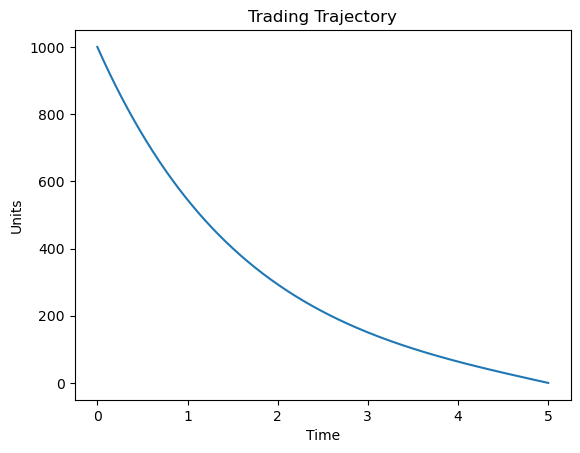

In [5]:
t = np.linspace(0, T, N)
plt.plot(t,trading_trajectory)
plt.title("Trading Trajectory")
plt.xlabel("Time")
plt.ylabel("Units")
plt.show()

In the Almgren-Chriss model, the initial trade block is liquidated to produce a smooth trading trajectory. This trajectory is the optimal strategy by which the model minimizes a combination of volatility risk and transactions costs. 

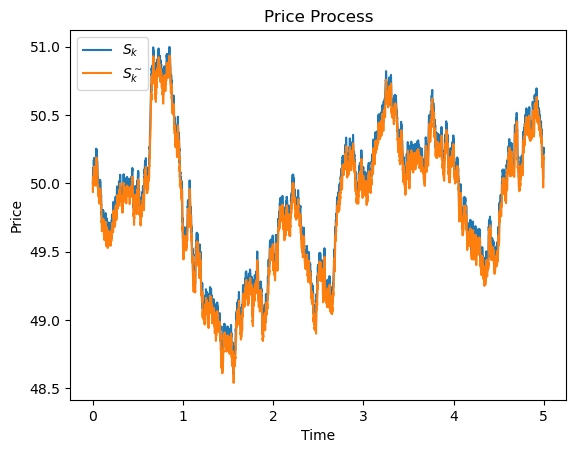

In [6]:
plt.plot(t,prices, label="$S_k$")
plt.plot(t,prices_tilde, label="$ S_k^{\sim}$")
plt.title("Price Process")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

In the figure above, the time series for both the market prices, $S_k$ and the sale prices, $\tilde{S}_k$ are presented. Given the temporary maket impact function, the sale prices tend to be diminished compared to the market prices .

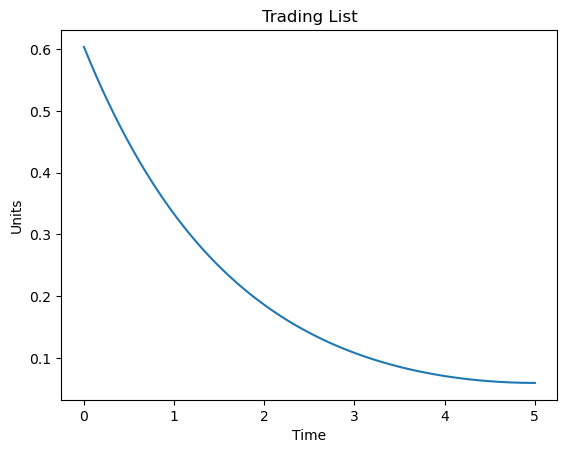

In [7]:
plt.plot(t[1:],trading_list[1:])
plt.title("Trading List")
plt.xlabel("Time")
plt.ylabel("Units")
plt.show()

In the figure above, the associated trade list is presented. Again, we see how the Almgren-Chriss model produces a result in which units of the security are traded in a smooth fashion over time. Notice that the strategy does not tend to trade large blocks of the security at once but instead gradually trades the security so that the minimization of volatility risk and trading costs is achieved. Initially, larger units are sold but over time the amount sold at a given time is decreasing.

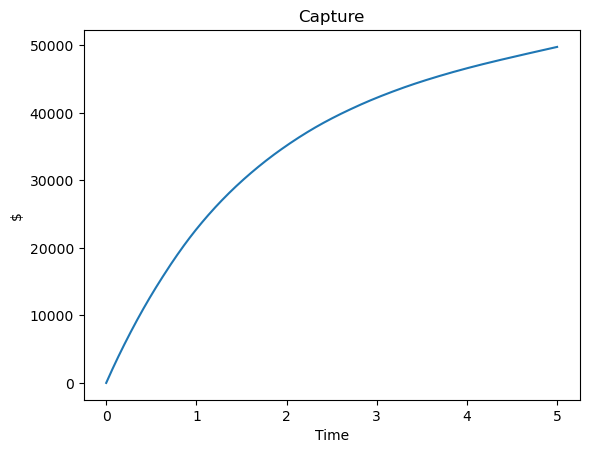

In [8]:
plt.plot(t,np.cumsum(trading_list*prices_tilde))
plt.title("Capture")
plt.xlabel("Time")
plt.ylabel("$")
plt.show()

The capture, as measured by $ \sum_{i=1}^N n_k \tilde{S}_k$, emphasizes the smooth gains made over time as a result of the optimal execution strategy. This metric will serve as an important benchmark, as we will use it analyze whether the Reinforecement Learning model has a similar outcomes or shape as the capture from the optimal execution strategy.

## Reinforcement Learning via Q-Learning

Borrowing from the concepts presented in Machine Learning for Trading (Ritter 2017),we implement the Q-learning algorithm:

$$ Q^{new}(S_t,A_t) \leftarrow (1-\alpha) Q(S_t,A_t) + \alpha (R_{t+1} + \gamma \cdot \max_a Q(S_t,a))$$

where $Q$ is a state-action matrix, $\alpha \in (0,1)$ is the learning rate, and $\gamma$ is a discount factor.

Our model takes the Almgren-Chriss price process dynamics, as described in the previous section, and utilizes a form of reward following the Almgren-Chriss implementation.

In [27]:
def index_list(L): return dict(zip(L, [x for x in range(0, len(L))]))

def runif(): return np.random.uniform(0, 1, 1)[0]


TickSizeStr = '0.1'
TickSize = float(TickSizeStr)
TickDecimals = abs(decimal.Decimal(TickSizeStr).as_tuple().exponent)

LotSize = 100
p_e = 50
MAX_HOLDING = 10 * LotSize
kappa = 1.0e-4

actionSpace = [round(-0.05 * x, 2) for x in range(21)]
holdings = [(round(h,2)) for h in np.arange(0, MAX_HOLDING + 0.05, 0.05)]
stateSpace = [(n, p) for n in holdings for p in priceGrid]

priceGrid = [round(TickSize * x, 2) for x in range(1, 1001)]
MIN_PRICE = min(priceGrid)
MAX_PRICE = max(priceGrid)


def snap_to_grid(price):
    x = round(price, TickDecimals)
    if x < MIN_PRICE: x = MIN_PRICE
    if x > MAX_PRICE: x = MAX_PRICE
    return x

In [21]:
class TradingEnvironment:
    def __init__(self, init, curr):
        self.initial = init
        self.current = curr # current state 

    def next_price(self, p, new_holding,last_holding):
        ## This function dictates law of motion
        sigma = 0.95
        gamma = 2.5*10**(-7)
        tau = 5/5000
        xi = np.random.normal(0, 1.0, 1)[0]
        new_price = p + sigma*(tau**0.5)*xi + gamma*(new_holding - last_holding)
        return new_price

    def reset(self):
        self.current = self.initial
        return self.current

    def step(self, action):
        cur_pos = self.current[0]
        cur_price = self.current[1]
        
        a_trade = action
        
        new_pos = round(max(cur_pos + a_trade, 0),1)
        new_price = snap_to_grid(self.next_price(cur_price, new_pos, cur_pos))
        
        trade = abs(cur_pos- new_pos)
        
        cost = TickSize * (trade + (trade ** 2) / LotSize)
        pnl = cur_pos * (new_price - cur_price) - cost
        capture = - a_trade * cur_price
        
        new_state = (new_pos, new_price)
        self.current = new_state
        reward = pnl - 0.5 * kappa * (pnl ** 2)
        return (new_state, reward, False, pnl, capture, a_trade)

In [22]:
class Learner:
    def __init__(self, action_space, state_space, learning_rate=0.001, discount_factor=0.999, exploration_rate=0.1, exploration_decay=1):
        self.action_space = action_space
        self.state_space = state_space
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.q_table = np.zeros((len(state_space), len(action_space)))
        
    def epsilon_greedy_policy(self, state):
        ## choose an action according to the epsilon greedy policy
        IF_GREEDY = np.random.uniform(0,1)
        state_index = self.state_space.index(state)
        if IF_GREEDY > self.exploration_rate:
            action = self.action_space[np.argmax(self.q_table[state_index])]
        else: 
            action = random.choice(self.action_space)
        return action
        
    def update(self, state, action, reward, next_state):
        state_index = self.state_space.index(state)
        next_state_index = self.state_space.index(next_state)
        action_index = self.action_space.index(action)
        
        old_q_value = self.q_table[state_index, action_index]
        next_max = np.max(self.q_table[next_state_index])
        
        new_q_value = (1 - self.learning_rate) * old_q_value + self.learning_rate * (reward + self.discount_factor * next_max)
        self.q_table[state_index, action_index] = new_q_value

    def decay_exploration(self):
        self.exploration_rate *= self.exploration_decay

In [24]:
def train(learner, environment, nsteps, ls_in):
    total_reward = 0
    state = environment.reset()
    for episode in range(nsteps):
        action = learner.epsilon_greedy_policy(state)
        next_state, reward, done, pnl, capture, shares_traded = environment.step(action)
        learner.update(state, action, reward, next_state)
        
        state = next_state
        total_reward += reward
        
        learner.decay_exploration()
        ls_in.append({"Episode": {episode}, "Total Reward": total_reward})

In [71]:
def run(learner, env, nstep):
    env.reset()
    pnl = []
    captures = []
    trading_list = []
    i = 0
    while ((i < nstep) or (env.current[0] > 0)):
        action = learner.epsilon_greedy_policy(env.current)
        next_state, reward, done, pl, capture, shares_traded = env.step(action)
        pnl.append(pl)
        captures.append(capture) 
        trading_list.append(shares_traded)
        i+=1
    return pnl, captures, trading_list

In [36]:
initial_state = (1000.0, 50.0)
env = TradingEnvironment(initial_state, initial_state)
learner = Learner(actionSpace, stateSpace, learning_rate = alpha, discount_factor = gamma, exploration_rate = epsilon)
kappa = 0.0001

episodes_ls = []
train(learner, env, int(1000), episodes_ls)

In [37]:
PnL, Captures_list, Trading_list = run(learner, env, 5000)

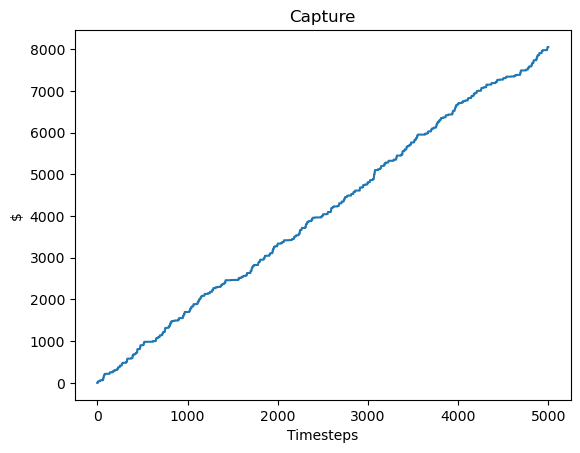

In [75]:
plt.plot(np.cumsum(Captures_list))
plt.xlabel("Timesteps")
plt.ylabel("$")
plt.title("Capture")
plt.show()

### Conclusion

Within the finite state-space framework, we use Q-learning to verify the optimal excution policy outlined in the Almgren-Chriss paper. With a Q-table completed after a thousand training steps, we run the algorithm for another 5000 iterations to capture \$8000 out of the entire \$50000 order orignially. An \$1039.7 PnL taking advantage of price variations has been achieved in addition to order sales. 

Capture trajectory looks more linear concavely increasing. This may due to the limited number of training iterations. In order to process larger and more granular holding range and state space, more computational power is required. It would be interesting to see what would convergence and trading trajectory would look like when we increase the number of training and running iterations.

The results of using the reinforcement learning model vary from that presented by Almgren-Chriss model in the previous section. In particular, we believe that such inconsistencies might result from our definition of the reward in the algorithm or limitation in the number of training iterations. Future work would aim to improve the reward so as more closely reproduce the Almgren-Chriss result. However, the Q-learning algorithm does manage to produce consistent profits apart from order sales indicating that there is potential to finetune model for a more optimal execution of orders.